In [1]:
from pyspark.sql import SparkSession

In [2]:
spark = SparkSession.builder.appName('ml-cls').getOrCreate()

In [3]:
df = spark.read.csv('D://DataSets//diabetes.csv', header = True, inferSchema = True)
df.printSchema()

root
 |-- preg: integer (nullable = true)
 |-- glucose: integer (nullable = true)
 |-- bp_diastolic: integer (nullable = true)
 |-- skin_triceps: integer (nullable = true)
 |-- insulin: integer (nullable = true)
 |-- bmi: double (nullable = true)
 |-- pedigree: double (nullable = true)
 |-- age: integer (nullable = true)
 |-- label: integer (nullable = true)



In [4]:
df.show(5)

+----+-------+------------+------------+-------+----+--------+---+-----+
|preg|glucose|bp_diastolic|skin_triceps|insulin| bmi|pedigree|age|label|
+----+-------+------------+------------+-------+----+--------+---+-----+
|   6|    148|          72|          35|      0|33.6|   0.627| 50|    1|
|   1|     85|          66|          29|      0|26.6|   0.351| 31|    0|
|   8|    183|          64|           0|      0|23.3|   0.672| 32|    1|
|   1|     89|          66|          23|     94|28.1|   0.167| 21|    0|
|   0|    137|          40|          35|    168|43.1|   2.288| 33|    1|
+----+-------+------------+------------+-------+----+--------+---+-----+
only showing top 5 rows



In [5]:
print((df.count(), len(df.columns)))

(768, 9)


In [6]:
df.filter(df.label==0).count()

500

### Data preparation and feature engineering

In [7]:
## See if we have missing values
from pyspark.sql.functions import isnull, when, count, col
df.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).show()

+----+-------+------------+------------+-------+---+--------+---+-----+
|preg|glucose|bp_diastolic|skin_triceps|insulin|bmi|pedigree|age|label|
+----+-------+------------+------------+-------+---+--------+---+-----+
|   0|      0|           0|           0|      0|  0|       0|  0|    0|
+----+-------+------------+------------+-------+---+--------+---+-----+



### Data preparation and feature engineering

In [8]:
import seaborn as sns

<AxesSubplot:>

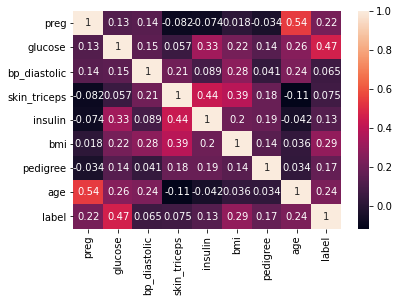

In [9]:
sns.heatmap(df.toPandas().corr(), annot = True)

### Drop unnecessary columns

In [10]:
df = df.drop('skin_triceps')
df = df.drop('bp_diastolic')

df.show(5)

+----+-------+-------+----+--------+---+-----+
|preg|glucose|insulin| bmi|pedigree|age|label|
+----+-------+-------+----+--------+---+-----+
|   6|    148|      0|33.6|   0.627| 50|    1|
|   1|     85|      0|26.6|   0.351| 31|    0|
|   8|    183|      0|23.3|   0.672| 32|    1|
|   1|     89|     94|28.1|   0.167| 21|    0|
|   0|    137|    168|43.1|   2.288| 33|    1|
+----+-------+-------+----+--------+---+-----+
only showing top 5 rows



In [11]:
X = df.drop('label')

### Assemble all the features with VectorAssembler

In [12]:
from pyspark.ml.feature import VectorAssembler

In [13]:
assembler = VectorAssembler(inputCols=X.columns, outputCol='features')
transformed_data = assembler.transform(df)
transformed_data.show(truncate=False)

+----+-------+-------+----+--------+---+-----+---------------------------------+
|preg|glucose|insulin|bmi |pedigree|age|label|features                         |
+----+-------+-------+----+--------+---+-----+---------------------------------+
|6   |148    |0      |33.6|0.627   |50 |1    |[6.0,148.0,0.0,33.6,0.627,50.0]  |
|1   |85     |0      |26.6|0.351   |31 |0    |[1.0,85.0,0.0,26.6,0.351,31.0]   |
|8   |183    |0      |23.3|0.672   |32 |1    |[8.0,183.0,0.0,23.3,0.672,32.0]  |
|1   |89     |94     |28.1|0.167   |21 |0    |[1.0,89.0,94.0,28.1,0.167,21.0]  |
|0   |137    |168    |43.1|2.288   |33 |1    |[0.0,137.0,168.0,43.1,2.288,33.0]|
|5   |116    |0      |25.6|0.201   |30 |0    |[5.0,116.0,0.0,25.6,0.201,30.0]  |
|3   |78     |88     |31.0|0.248   |26 |1    |[3.0,78.0,88.0,31.0,0.248,26.0]  |
|10  |115    |0      |35.3|0.134   |29 |0    |[10.0,115.0,0.0,35.3,0.134,29.0] |
|2   |197    |543    |30.5|0.158   |53 |1    |[2.0,197.0,543.0,30.5,0.158,53.0]|
|8   |125    |0      |0.0 |0

### Machine learning Model Building

In [14]:
# Split the data
(X_train, X_test) = transformed_data.randomSplit([0.8,0.2])

### Classifier

In [15]:
from pyspark.ml.classification import DecisionTreeClassifier
clf = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)

In [16]:
model = clf.fit(X_train)

In [17]:
predictions = model.transform(X_test)
predictions.select('glucose', 'insulin', 'bmi', 'pedigree', 'age', 'label','prediction').show(5)

+-------+-------+----+--------+---+-----+----------+
|glucose|insulin| bmi|pedigree|age|label|prediction|
+-------+-------+----+--------+---+-----+----------+
|     94|      0| 0.0|   0.256| 25|    0|       0.0|
|     95|     36|37.4|   0.247| 24|    1|       0.0|
|     95|    105|44.6|   0.366| 22|    0|       0.0|
|    101|      0|35.7|   0.198| 26|    0|       0.0|
|    102|     78|40.6|   0.496| 21|    0|       0.0|
+-------+-------+----+--------+---+-----+----------+
only showing top 5 rows



In [18]:
predictions.groupBy('label', 'prediction').count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|   27|
|    0|       0.0|   76|
|    1|       1.0|   36|
|    0|       1.0|   16|
+-----+----------+-----+



### Model Evaluation

In [19]:
y_true = predictions.select('label').rdd.flatMap(list).collect()
y_pred = predictions.select('prediction').rdd.flatMap(list).collect()

In [20]:
# calculate accuracy
from sklearn import metrics

In [21]:
cm = metrics.confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[76 16]
 [27 36]]


In [22]:
import matplotlib.pyplot as plt

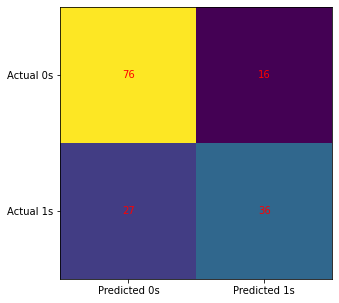

In [23]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

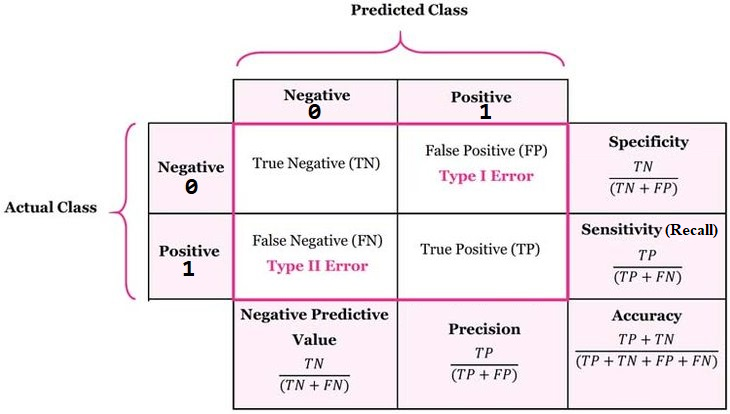

### Evaluating a Classification Model
#### Basic terminology

###### True Positives (TP): we correctly predicted that they do have diabetes
###### True Negatives (TN): we correctly predicted that they don't have diabetes
###### False Positives (FP): we incorrectly predicted that they do have diabetes (a "Type I error")
###### False Negatives (FN): we incorrectly predicted that they don't have diabetes (a "Type II error")

In [24]:
#[row, column]
#(Actual, Predict)
TP = cm[1, 1]      
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]

## Metrics computed from a confusion matrix¶
##### Classification Accuracy: Overall, how often is the classifier correct? (TP + TN) / (TP + TN + FP + FN)
##### Classification Error (Misclassification Rate): Overall, how often is the classifier incorrect? (FP + FN) / (TP + TN + FP + FN)
#####                                                                            Classification Error    =   1 -  Classification Accuracy
##### Sensitivity (Recall): When the actual value is positive, how often is the prediction correct? TP / (FN + TP)
##### Specificity: When the actual value is negative, how often is the prediction correct? TN / (TN + FP)
##### Precision: When a positive value is predicted, how often is the prediction correct? TP / (TP + FP)
##### False Positive Rate: When the actual value is negative, how often is the prediction incorrect? FP / (TN + FP)

In [25]:
accuracy = (TN + TP) / (TN + TP + FN + FP)
recall = TP / (TP + FN)
specificity = TN / (TN + FP)
precision = TP / (TP + FP)

In [26]:
print('Metrics computed from a confusion matrix')
print("Accuracy:\t", accuracy)
print("Classification Eerror:", 1 - accuracy)
print("Sensitivity/Recall:\t", recall)
print("Specificity:\t", specificity)
print("Precision:\t", precision)
print("False_Positive_Rate:", 1 - TN / (TN + FP))
print('###########################################')

Metrics computed from a confusion matrix
Accuracy:	 0.7225806451612903
Classification Eerror: 0.2774193548387097
Sensitivity/Recall:	 0.5714285714285714
Specificity:	 0.8260869565217391
Precision:	 0.6923076923076923
False_Positive_Rate: 0.17391304347826086
###########################################
